## Baseline Model 1: Logistic Regression

In this Jupyter Notebook, we will build a logistic regression model as our first model given the fact that Logit model performs generally well on solving binary classification problems and it is not computationally expensive to train a logit model. We will use a subset of the data (1000 samples) for all models' training as it is easy for the Google Colab's GPU ram to run out because of how big the dataset is.

## 0. Dependencies

If you have not installed openCV, run the following code

In [ ]:
# ! pip install opencv-python


Data is from UTKFace
https://susanqq.github.io/UTKFace/

"crop_part_1.tar.gz" in "Aligned&Cropped Faces" was used

If you use Google Colab, run the code to monte at the drive.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the packages

In [ ]:
import cv2
import os
import random
import numpy as np
import pandas as pd


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import time
from sklearn.linear_model import LogisticRegression
import matplotlib
from sklearn import metrics
from sklearn.metrics import precision_recall_curve


## 1. Subsetting and Loading

Due to the limitation of time and RAM, subset could be used. Specify $n$ to get n random samples from the whole dataset.

In [ ]:
# set a seed
random.seed(328)

# define dir
data_dir = "./crop_part1"
# data_dir = "/content/drive/My Drive/crop_part1"

# random sampling from 9780 samples
n = 1000
fnames_subset = random.sample(os.listdir(data_dir), n)


Constructing our response variable(gender) and variable(race). 

In [ ]:
y = []  # 0 (male) or 1 (female)
y_race = []
for fname in fnames_subset:
    temp = fname.split("_")
    y.append(int(temp[1]))
    if temp[2] in ("0", "1"):
        y_race.append(int(temp[2]))
    elif temp[2] in ("2", "3"):
        y_race.append(2)
    else:
        y_race.append(3)
    pass


Storing the values of the pixels into a 4D array. (Number of samples, Red Channel, Green Channel, Blue Channel)

In [ ]:
X_rgb = list()
X_origin_dict = dict()
for i, fname in enumerate(fnames_subset):
    # construct dir
    dir = data_dir + "/" + fname

    # read the data
    dat = cv2.imread(dir)

    # convert to rgb
    dat = cv2.cvtColor(dat, cv2.COLOR_BGR2RGB)

    # store the original data
    X_origin_dict[i] = dat

    # store the data
    X_rgb.append(dat)


## 2. Preprocessing

In EDA, we know there is one sample of an unknown label, delete that sample.

In [ ]:
find = False
for i, lab in enumerate(y):
    if lab == 3:
        find = True
        delete = i

if find:
    y.pop(delete)
    y_race.pop(delete)
    X_rgb.pop(delete)


array([[[ 45,  45,  47],
        [ 47,  47,  49],
        [ 49,  49,  51],
        ...,
        [ 42,  42,  42],
        [ 42,  42,  42],
        [ 42,  42,  42]],

       [[ 47,  47,  49],
        [ 48,  48,  50],
        [ 49,  49,  51],
        ...,
        [ 42,  42,  42],
        [ 42,  42,  42],
        [ 42,  42,  42]],

       [[ 49,  49,  51],
        [ 49,  49,  51],
        [ 49,  49,  51],
        ...,
        [ 42,  42,  42],
        [ 42,  42,  42],
        [ 42,  42,  42]],

       ...,

       [[229, 160, 103],
        [218, 149,  92],
        [205, 138,  83],
        ...,
        [ 87,  82,  89],
        [ 87,  84,  91],
        [ 88,  85,  92]],

       [[236, 167, 110],
        [227, 158, 101],
        [215, 148,  93],
        ...,
        [ 86,  81,  88],
        [ 86,  83,  90],
        [ 88,  85,  92]],

       [[241, 172, 115],
        [232, 163, 106],
        [221, 154,  99],
        ...,
        [ 85,  80,  87],
        [ 86,  83,  90],
        [ 87,  84,  91]]

In [ ]:
# convert to np array
y = np.array(y)
y_race = np.array(y_race)
X_rgb = np.array(X_rgb)
print("The shape of the X_rgb is:", X_rgb.shape)


The shape of the X_rgb is: (9779, 200, 200, 3)


## 3. Modeling

### Building the Logistic Regression Model

Train, validation, test split. Train: 80%, validation: 10%, test: 10%

In [ ]:
X_rgb_train, X_rgb_test, y_train, y_test = train_test_split(
    X_rgb, y, test_size=0.1, random_state=329
)

X_rgb_train, X_rgb_val, y_train, y_val = train_test_split(
    X_rgb_train, y_train, test_size=(0.1 / 0.9), random_state=525
)


Flatten the X_rgb lists of arrays as each image is represented as a 200* 200 matrix.

In [ ]:
X_rgb_flattened_train = np.array([x.flatten() for x in X_rgb_train])
X_rgb_flattened_val = np.array([x.flatten() for x in X_rgb_val])
X_rgb_flattened_test = np.array([x.flatten() for x in X_rgb_test])


Standardizing to mean 0 and stardard deviation 1.

In [ ]:
# feature scaling
scaler = StandardScaler()
scaler.fit(X_rgb_flattened_train)

X_rgb_flattened_train_scaled = X_rgb_flattened_train.copy()
X_rgb_flattened_train_scaled = scaler.transform(X_rgb_flattened_train)
X_rgb_flattened_val_scaled = scaler.transform(X_rgb_flattened_val)
X_rgb_flattened_test_scaled = scaler.transform(X_rgb_flattened_test)


Set up the list of hyperparameter C (inverse of regularization strength).

In [ ]:
# construct a list of C
C = []
temp = -4
step = (4 - (-4)) / (20 - 1)
while temp <= 4:
    C.append(temp)
    temp += step
C.pop()
C.append(4)
C_log = copy.deepcopy(C)
C = np.array(C)
C = np.power(10, C)
print("There are {} C values.".format(len(C)))
print("The C values are:", C)


There are 20 C values.
The C values are: [1.00000000e-04 2.63665090e-04 6.95192796e-04 1.83298071e-03
 4.83293024e-03 1.27427499e-02 3.35981829e-02 8.85866790e-02
 2.33572147e-01 6.15848211e-01 1.62377674e+00 4.28133240e+00
 1.12883789e+01 2.97635144e+01 7.84759970e+01 2.06913808e+02
 5.45559478e+02 1.43844989e+03 3.79269019e+03 1.00000000e+04]


Try different C value for logistic regression model.

Hyper parameter tuning of the logistic regression model. We use LASSO instead of ridge regression here because image data is sparse and its dimension is high. We use liblinear as the solver because we chose LASSO. In each loop, we fit a new model with different C and evaluate the AUC score of the prediction on the validation set.

In [ ]:
# init dictionaries for storing results of each interation
num_parameters_l1 = []
auc_l1 = []

# loop through 20 C values
for i, c in enumerate(C):
    model_lr = LogisticRegression(
        penalty="l1", C=c, solver="liblinear", random_state=214
    )

    model_lr.fit(X_rgb_flattened_train_scaled, y_train)

    # counting non-zero parameters
    cnt = 0
    for coef in model_lr.coef_.flatten():
        if coef != 0:
            cnt += 1

    num_parameters_l1.append(cnt)

    # evaluate on val set
    y_val_prob = model_lr.predict_proba(X_rgb_flattened_val_scaled)[:, 1]

    # calculating the auc
    auc_model_lr = metrics.roc_auc_score(y_val, y_val_prob)
    auc_l1.append(auc_model_lr)
    pass


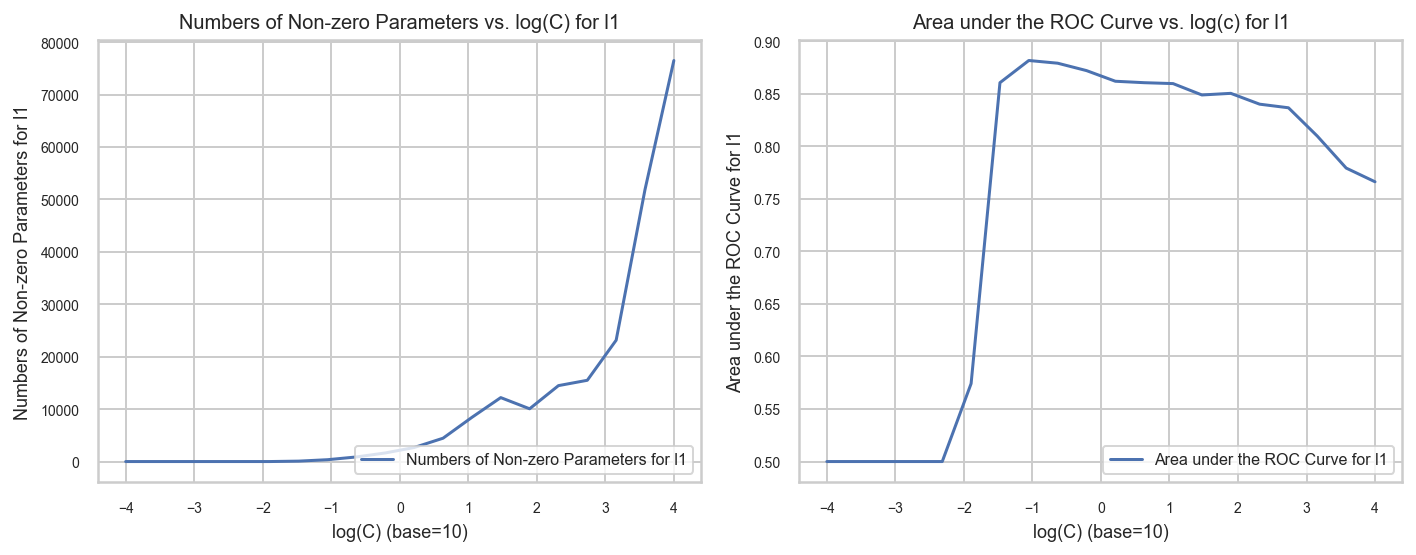

In [ ]:
# set format as retina
%config InlineBackend.figure_format = "retina"

# set theme
sns.set_theme(style="whitegrid")

# set subplots to 2*2
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# data for the subplots
dat = [num_parameters_l1, auc_l1]

y_lab = ["Numbers of Non-zero Parameters for l1",
         "Area under the ROC Curve for l1"]

title = [
    "Numbers of Non-zero Parameters vs. log(C) for l1",
    "Area under the ROC Curve vs. log(c) for l1"
]

# make a loop for each plot
for i in range(2):
    axs[i].plot(C_log, dat[i],
                    label=y_lab[i])

    # set the title for each subplot
    axs[i].set_title(
        title[i], fontsize=10
    )

    # set labels
    axs[i].set_xlabel("log(C) (base=10)", fontsize=9)
    axs[i].set_ylabel(y_lab[i], fontsize=9)

    # set ticks
    axs[i].tick_params(labelsize=7)

    # set legends
    legend = axs[i].legend(prop={"size": 8}, loc="lower right")


# use tight layout to save space
plt.tight_layout()

plt.show()

$C=0.0886$ is the optimal choice

In [ ]:
max_auc, ind = 0, 0
for i, auc in enumerate(auc_l1):
    if auc > max_auc:
        max_auc = auc
        ind = i
c_rgb = C[ind]
print("The best C is: {:.4f}".format(c_rgb))


The best C is: 0.0886


Train the final logistic regression model.

In [ ]:
model_lr_rgb = LogisticRegression(
    penalty="l1", C=0.0886, solver="liblinear", random_state=214
)

model_lr_rgb.fit(X_rgb_flattened_train_scaled, y_train)

# evaluate on test set
y_test_prob = model_lr_rgb.predict_proba(X_rgb_flattened_test_scaled)[:, 1]

# calculating the auc
auc_model_lr_rgb = metrics.roc_auc_score(y_test, y_test_prob)
print("The AUC is {:.5f}".format(auc_model_lr_rgb))

ap_model_lr_rgb = metrics.average_precision_score(y_test, y_test_prob)
print("The AP is {:.5f}".format(ap_model_lr_rgb))


The AUC is 0.84040
The AP is 0.86018


Test and visulization on test set. ROC and PR curves are plotted as follow.

In [ ]:
models = ["Logistic Regression"]
fpr_dict, tpr_dict = dict(), dict()
pc_dict, rc_dict = dict(), dict()
auc_dict, ap_dict = dict(), dict()

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_prob)
pc, rc, thresholds = precision_recall_curve(y_test, y_test_prob)

fpr_dict[models[0]] = fpr
tpr_dict[models[0]] = tpr
pc_dict[models[0]] = pc
rc_dict[models[0]] = rc
auc_dict[models[0]] = auc_model_lr_rgb
ap_dict[models[0]] = ap_model_lr_rgb


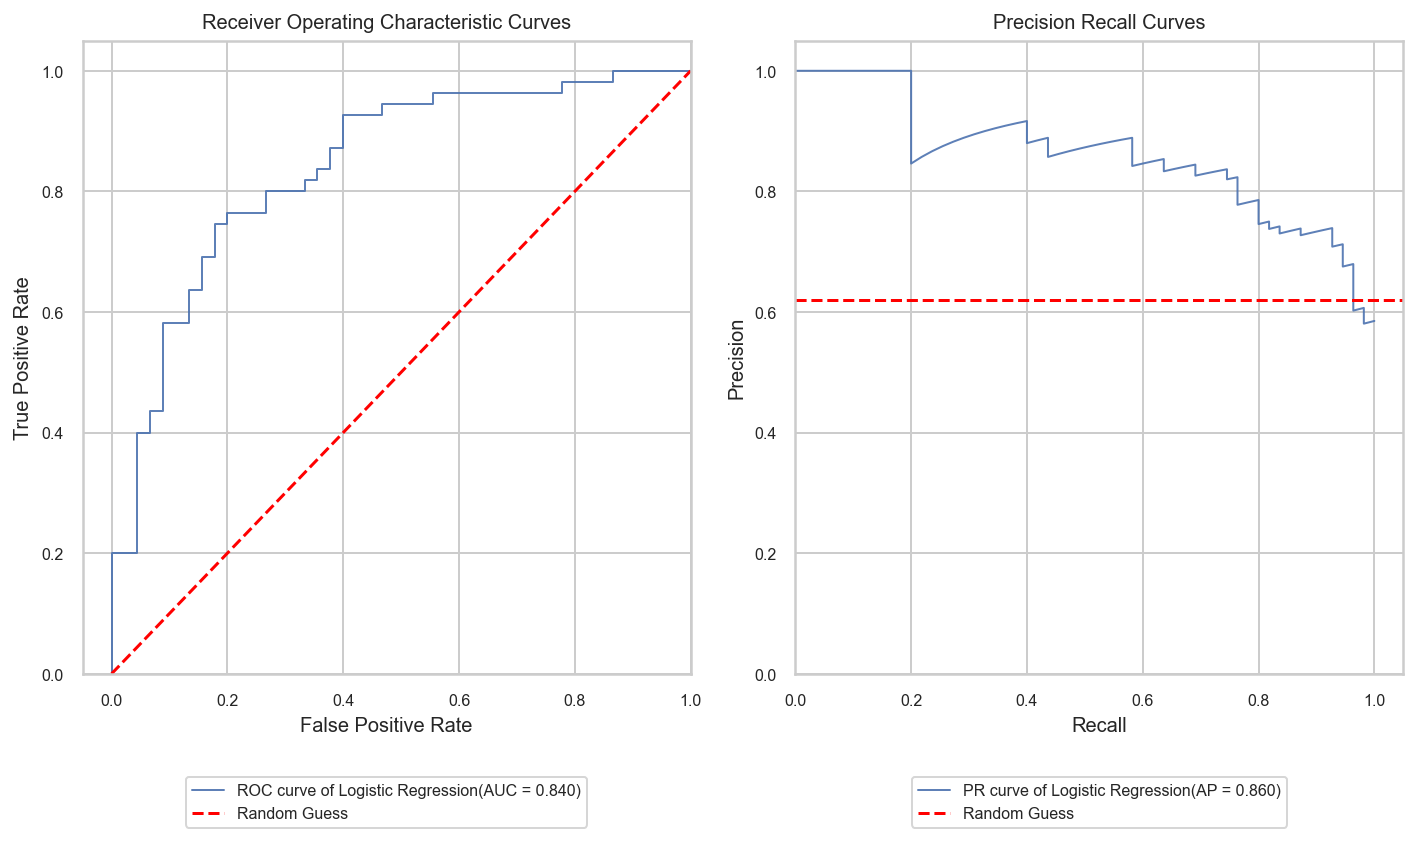

In [ ]:
# set format as retina
%config InlineBackend.figure_format = "retina"

# set theme
sns.set_theme(style="whitegrid")

# set subplots to 1*2
fig, axs = plt.subplots(1, 2, figsize=(10,6))

# ROC curves
for i in range(len(models)):
    k = models[i]
    axs[0].plot(
          fpr_dict[k],
          tpr_dict[k],
          label="ROC curve of {}(AUC = {:.3f})".format(k, auc_dict[k]),
          lw = 1,
          alpha = 0.9
    )

# PR curves
# reference line
axs[0].plot([0, 1], [0, 1],
        linestyle="dashed",
        lw=1.5,
        color="red",
        label="Random Guess")

axs[0].set_title("Receiver Operating Characteristic Curves", fontsize = 10)

axs[0].set_xlabel("False Positive Rate", fontsize = 10)
axs[0].set_ylabel("True Positive Rate", fontsize = 10)

axs[0].set_xlim(-0.05, 1)
axs[0].set_ylim(0, 1.05)

# PR curve for each model
for i in range(len(models)):
    k = models[i]
    axs[1].plot(
            rc_dict[k],
            pc_dict[k],
            label="PR curve of {}(AP = {:.3f})".format(k, ap_dict[k]),
            lw = 1,
            alpha = 0.9
    )


# reference line
axs[1].axhline(y = np.sum(y_val) / len(y_val),
        linestyle="dashed",
        lw=1.5,
        color="red",
        label="Random Guess")

axs[1].set_title("Precision Recall Curves", fontsize = 10)

axs[1].set_xlabel("Recall", fontsize = 10)
axs[1].set_ylabel("Precision", fontsize = 10)

axs[1].set_xlim(0, 1.05)
axs[1].set_ylim(0, 1.05)

for j in range(2):
    axs[j].tick_params(labelsize=8)
        
    legend = axs[j].legend(prop={'size': 8},
                           loc="upper center", bbox_to_anchor=(0.5, -0.15))

# use tight layout to save space
plt.tight_layout()

plt.show()

### Try: Logistic Regression in grey-scale

We then try to see if making the photos into black and white by removing the rgb channel will affect the prediction ability. We want to play around with this because training on thousands of colored images is very computationally expensive. But it turns out that the grey-scale input does make the model perform worse. So from now on, we will not use grey scaled images for our study.

Same workflow is adopted here.

In [ ]:
X_grey_train = np.array([cv2.cvtColor(dt, cv2.COLOR_BGR2GRAY) for dt in X_rgb_train])
X_grey_val = np.array([cv2.cvtColor(dt, cv2.COLOR_BGR2GRAY) for dt in X_rgb_val])
X_grey_test = np.array([cv2.cvtColor(dt, cv2.COLOR_BGR2GRAY) for dt in X_rgb_test])


In [ ]:
X_grey_flattened_train = np.array([x.flatten() for x in X_grey_train])
X_grey_flattened_val = np.array([x.flatten() for x in X_grey_val])
X_grey_flattened_test = np.array([x.flatten() for x in X_grey_test])


In [ ]:
# feature scaling
scaler = StandardScaler()
scaler.fit(X_grey_flattened_train)

X_grey_flattened_train_scaled = X_grey_flattened_train.copy()
X_grey_flattened_train_scaled = scaler.transform(X_grey_flattened_train)
X_grey_flattened_val_scaled = scaler.transform(X_grey_flattened_val)


In [ ]:
# init dictionaries for storing results of each interation
num_parameters_l1_grey = []
auc_l1_grey = []

# loop through 20 C values
for i, c in enumerate(C):
    model_lr = LogisticRegression(
        penalty="l1", C=c, solver="liblinear", random_state=214
    )

    model_lr.fit(X_grey_flattened_train_scaled, y_train)

    # counting non-zero parameters
    cnt = 0
    for coef in model_lr.coef_.flatten():
        if coef != 0:
            cnt += 1

    num_parameters_l1_grey.append(cnt)

    # evaluate on val set
    y_val_prob = model_lr.predict_proba(X_grey_flattened_val_scaled)[:, 1]

    # calculating the auc
    auc_model_lr = metrics.roc_auc_score(y_val, y_val_prob)
    auc_l1_grey.append(auc_model_lr)
    pass


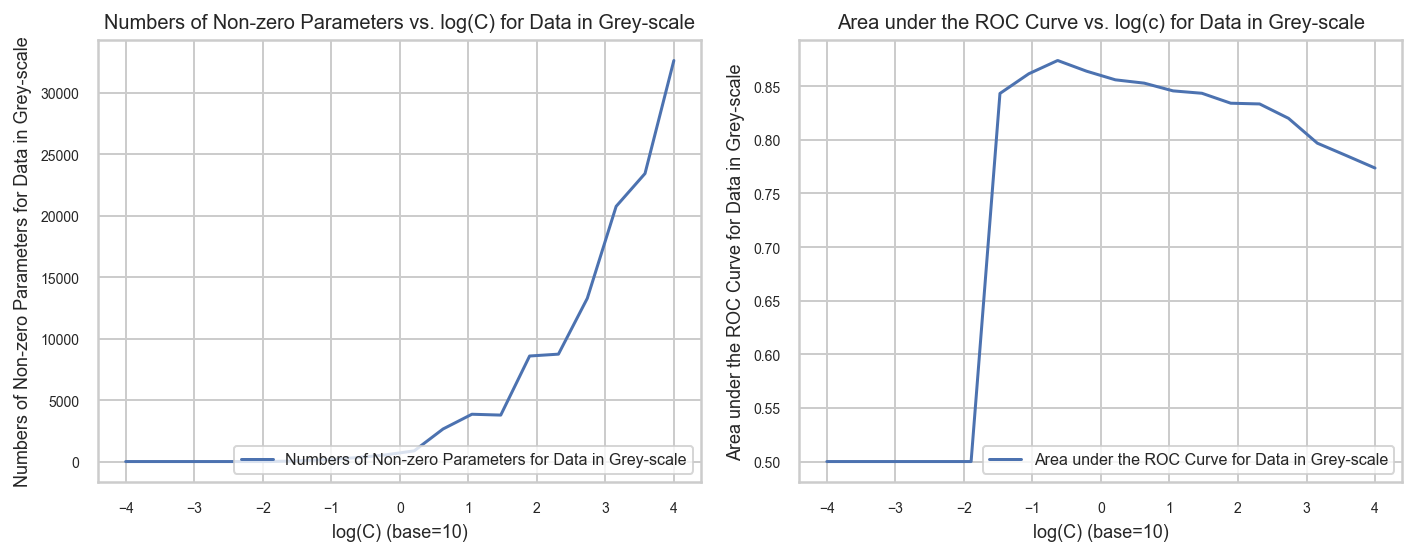

In [ ]:
# set format as retina
%config InlineBackend.figure_format = "retina"

# set theme
sns.set_theme(style="whitegrid")

# set subplots to 2*2
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# data for the subplots
dat = [num_parameters_l1_grey, auc_l1_grey]

y_lab = ["Numbers of Non-zero Parameters for Data in Grey-scale",
         "Area under the ROC Curve for Data in Grey-scale"]

title = [
    "Numbers of Non-zero Parameters vs. log(C) for Data in Grey-scale",
    "Area under the ROC Curve vs. log(c) for Data in Grey-scale"
]

# make a loop for each plot
for i in range(2):
    axs[i].plot(C_log, dat[i],
                    label=y_lab[i])

    # set the title for each subplot
    axs[i].set_title(
        title[i], fontsize=10
    )

    # set labels
    axs[i].set_xlabel("log(C) (base=10)", fontsize=9)
    axs[i].set_ylabel(y_lab[i], fontsize=9)

    # set ticks
    axs[i].tick_params(labelsize=7)

    # set legends
    legend = axs[i].legend(prop={"size": 8}, loc="lower right")


# use tight layout to save space
plt.tight_layout()

plt.show()

In [ ]:
max_auc, ind = 0, 0
for i, auc in enumerate(auc_l1_grey):
    if auc > max_auc:
        max_auc = auc
        ind = i
c_grey = C[ind]
print("The best C is: {:.4f}".format(c_grey))


The best C is: 0.2336


In [ ]:
model_lr_rgb = LogisticRegression(
    penalty="l1", C=c_grey, solver="liblinear", random_state=214
)

model_lr_rgb.fit(X_grey_flattened_train_scaled, y_train)

# evaluate on val set
y_val_prob = model_lr_rgb.predict_proba(X_grey_flattened_val_scaled)[:, 1]

# calculating the auc
auc_model_lr_rgb = metrics.roc_auc_score(y_val, y_val_prob)
print("The AUC is {:.5f}".format(auc_model_lr_rgb))

# ap
ap_model_lr_rgb = metrics.roc_auc_score(y_val, y_val_prob)
print("The AUC is {:.5f}".format(auc_model_lr_rgb))


The AUC is 0.87397


The grey-scale input is worse in this case. It may because of some information loss. Next, we will build a random forest model to see if the performance will be improved.